In [1]:
import numpy as np
import scipy as sc
import allantools as at

import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter, freqz
from scipy.fft import fft, ifft, fftfreq

offset = 10 # Volts
amp = 5e-6 # noise amplitude
time_step = 0.01 # s
rate = 1/time_step
measurements = 100000
time = np.arange(0, measurements*time_step, time_step)

# Dealing with noise complaints

# What do we want?

regarding trap DC the goal is clear: 

the minimum of the allan deviation should be placed where its needed, e.g. for an axial spectrum with dip fit at something like 20-100s (10-40 mHz resolution). For phase measurements its rather at 2-6 seconds (5-15 mHz resolution)

The following examples are more of a qualitative nature, since long data sets cost too much time to create and especially to make allan plots out of them AND I need the high measurement rate of 1000 measurements/second to apply filter in the end and compare well.

## Different types of noise:

**the high frequency broadband noise is white noise:** When you measure this, say using a differential amplifier and an oszilloscope there are two things to consider when trying to compare with other measurements: 1. Measuring peak to peak is easy, but dont forget you might want to convert that to root mean square! 2. The sampling rate is important! Either store the data including time array or write down the sampling rate to the peak to peak measurement. When sampling slower, peak-to-peak will get smaller since you are effectivly averaging!

**1/f noise is pink noise:** Kind of in between... If measured fast enough (20-50Hz), maybe with a nano-voltmeter, you should be able to measure the whole allan deviation directly, otherwise you might want to view different time ranges on the oscilloscopy and measure peak-to-peak. Gather some statistics though.

**the low frequency drift is brown noise:** This you measure with the fluke or nano-voltmeter, plain and easy value over time.

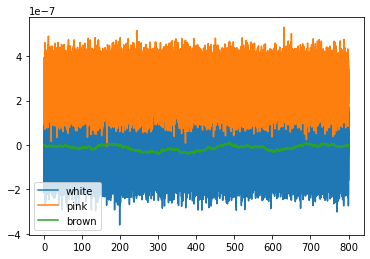

In [12]:
white = at.noise.white(measurements)*amp
plt.plot(time, white, label='white')

pink = at.noise.pink(measurements, depth=80)/5*amp
plt.plot(time, pink, label='pink')

#violet = at.noise.violet(measurements, b2=time_step**3, fs=rate)#/250
#plt.plot(time, violet, label='violet')

brown = at.noise.brown(measurements, b_minus2=time_step/100, fs=rate)*amp
plt.plot(time, brown, label='brown')
plt.legend()
plt.show()

allans = {}
specs = {}

N = measurements
T = time_step
xf = fftfreq(N, T)[:N//2]

(t2, ad, ade, adn) = at.adev(white, rate=rate, data_type="freq", taus=time)
allans['white'] = t2, ad
yf = fft(white)
specs['white'] = xf, 2.0/N * np.abs(yf[0:N//2])

(t2, ad, ade, adn) = at.adev(white[::4], rate=rate/4, data_type="freq", taus=time[::4]) 
allans['white /4 samples'] = t2, ad
Tquarter = time_step*4
xf = fftfreq(N, Tquarter)[:N//2]
specs['white /4 samples'] = xf, 2.0/N * np.abs(yf[0:N//2])

(t2, ad, ade, adn) = at.adev(pink, rate=rate, data_type="freq", taus=time) 
allans['pink'] = t2, ad
yf = fft(pink)
specs['pink'] = xf, 2.0/N * np.abs(yf[0:N//2])

#(t2, ad, ade, adn) = at.adev(violet, rate=rate, data_type="freq", taus=time) 
#plt.loglog(t2, ad, label='violet')

(t2, ad, ade, adn) = at.adev(brown, rate=rate, data_type="freq", taus=time) 
allans['brown'] = t2, ad
yf = fft(brown)
specs['brown'] = xf, 2.0/N * np.abs(yf[0:N//2])

(t2, ad, ade, adn) = at.adev(white+brown, rate=rate, data_type="freq", taus=time)
allans['white+brown'] = t2, ad
yf = fft(white+brown)
specs['white+brown'] = xf, 2.0/N * np.abs(yf[0:N//2])

(t2, ad, ade, adn) = at.adev(white+pink+brown, rate=rate, data_type="freq", taus=time) 
allans['white+pink+brown'] = t2, ad
yf = fft(white+pink+brown)
specs['white+pink+brown'] = xf, 2.0/N * np.abs(yf[0:N//2])




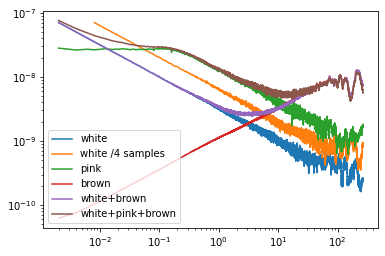

In [13]:

for key, data in allans.items():
    plt.loglog(data[0], data[1], label=key)
    
plt.legend()
plt.show()



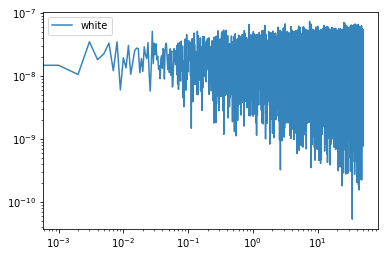

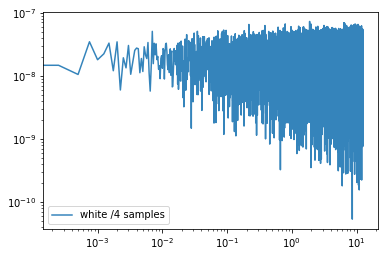

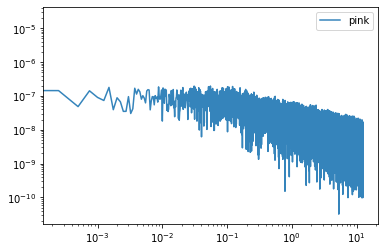

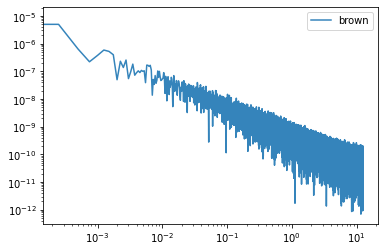

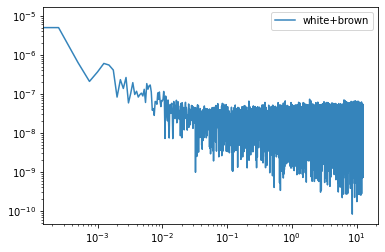

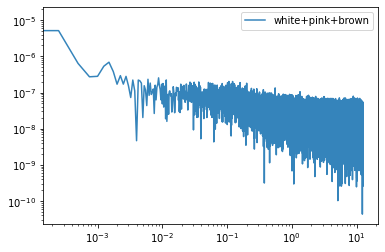

In [4]:
for key, data in specs.items():
    #if not key=="white": continue
    plt.loglog(data[0], data[1], label=key, alpha=0.9)
    plt.legend()
    plt.show()


## White noise of different amplitude (+ same drift):

1e-05
5e-06
4e-06
2e-06
1e-06
5e-07


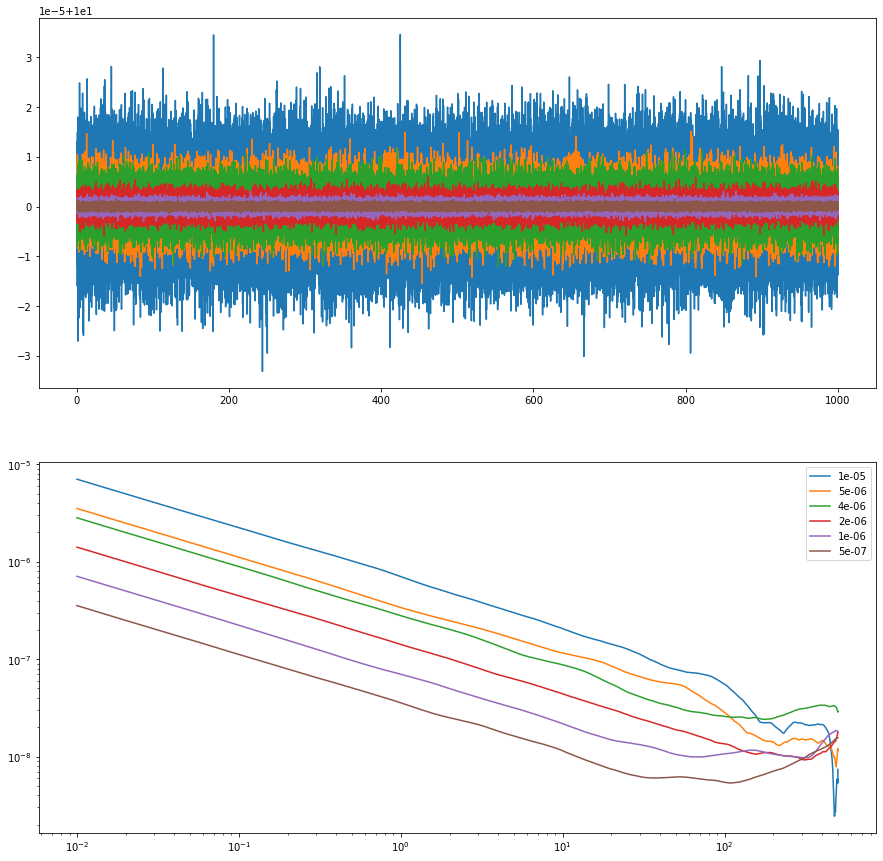

In [5]:
time_step = 0.01 # s
rate = 1/time_step
measurements = 100000
time = np.arange(0, measurements*time_step, time_step)
amplitudes = [1e-5, 5e-6, 4e-6, 2e-6, 1e-6, 5e-7]

drift = +5e-11 # per second

fig, axs = plt.subplots(2, figsize=(15,15))

for amp in amplitudes:
    print(amp)
    signal = at.noise.white(measurements)*amp + offset
    #signal /= offset
    signal += np.linspace(0, drift*measurements*time_step, measurements)
    axs[0].plot(time, signal, label=amp)

    # Compute the overlapping ADEV
    (t2, ad, ade, adn) = at.oadev(signal, rate=rate, data_type="freq", taus=time) 
    axs[1].loglog(t2, ad, label=amp)
    
plt.legend()
plt.show()

## White noise with different drift (+ same amplitude):

c:\program files\python37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


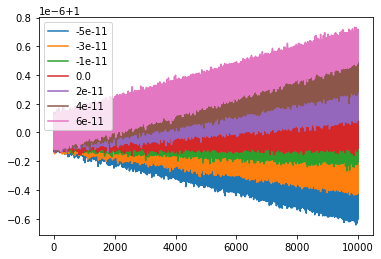

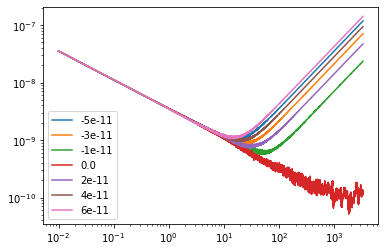

In [6]:
time_step = 0.01 # s
rate = 1/time_step
measurements = 1000000
time = np.arange(0, measurements*time_step, time_step)
amps = 1e-6

drifts = [-5e-11, -3e-11, -1e-11, 0.0, 2e-11, 4e-11, 6e-11]  # per second

for drift in drifts:
    signal = at.noise.white(measurements)*amp + offset
    signal /= offset
    signal += np.linspace(0, drift*measurements*time_step, measurements)

    plt.plot(time, signal, label=drift)
plt.legend()
plt.show()

for drift in drifts:
    signal = at.noise.white(measurements)*amp + offset
    signal /= offset
    signal += np.linspace(0, drift*measurements*time_step, measurements)

    # Compute the overlapping ADEV
    (t2, ad, ade, adn) = at.adev(signal, rate=rate, data_type="freq", taus=time) 
    plt.loglog(t2, ad, label=drift)
    
plt.legend()
plt.show()

## Mixed noise of different amplitude (+ same drift):

c:\program files\python37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


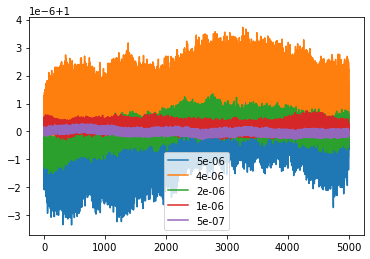

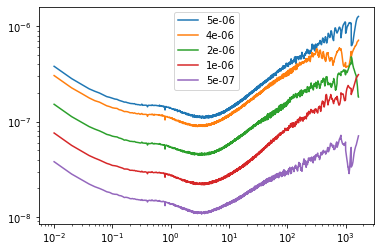

In [7]:
time_step = 0.01 # s
rate = 1/time_step
measurements = 500000
time = np.arange(0, measurements*time_step, time_step)
amplitudes = [5e-6, 4e-6, 2e-6, 1e-6, 5e-7]

drift = +1e-11 # per second
drift = 0 # per second

for amp in amplitudes:
    brownamp = amp/10
    signal = at.noise.white(measurements)*amp + offset
    signal += at.noise.pink(measurements, depth=80)/5*amp
    signal += at.noise.brown(measurements, b_minus2=time_step, fs=rate)*brownamp
    signal /= offset
    signal += np.linspace(0, drift*measurements*time_step, measurements)

    plt.plot(time, signal, label=amp)
plt.legend()
plt.show()

for amp in amplitudes:
    brownamp = amp/3
    signal = at.noise.white(measurements)*amp + offset
    signal += at.noise.pink(measurements, depth=80)/5*amp
    signal += at.noise.brown(measurements, b_minus2=time_step, fs=rate)*brownamp
    signal /= offset
    signal += np.linspace(0, drift*measurements*time_step, measurements)

    # Compute the overlapping ADEV
    (t2, ad, ade, adn) = at.adev(signal, rate=rate, data_type="freq", taus=time) 
    plt.loglog(t2, ad, label=amp)
    
plt.legend()
plt.show()

## Mixed noise with different LOWPASS filters (+ same drift & amplitude):

c:\program files\python37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


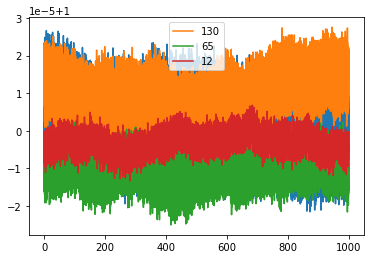

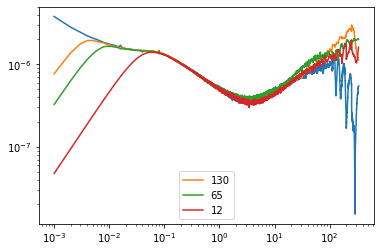

In [8]:
time_step = 0.001 # s
rate = 1/time_step
measurements = 1000000
time = np.arange(0, measurements*time_step, time_step)
#amplitudes = [5e-6, 4e-6, 2e-6, 1e-6, 5e-7]
#amp = 5e-6 # V
amp = 50e-6 # V

drift = +1e-10 # per second
drift = 0 # per second

cutoff = 130 # one RC filter, 40k, 22n
cutoff = 65 # two RC filter, each 40k, 22n
cutoff = 12 # three RC filter, two 40k, 22n + 100Meg, 110p
cutoffs = [None, 130, 65, 12]

def butter_lowpass(cutoff, fs, order=6):
    #print(fs, cutoff)
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

#for amp in amplitudes:
for cutoff in cutoffs:
    brownamp = amp/3
    signal = at.noise.white(measurements)*amp + offset
    signal += at.noise.pink(measurements, depth=80)/5*amp
    signal += at.noise.brown(measurements, b_minus2=time_step, fs=rate)*brownamp
    if cutoff is not None:
        signal = butter_lowpass_filter(signal, cutoff, fs=rate, order=6)
    signal /= offset
    signal += np.linspace(0, drift*measurements*time_step, measurements)

    #plt.plot(time[:-1000], signal[1000:], label=amp)
    plt.plot(time[:-1000], signal[1000:], label=cutoff)
plt.legend()
plt.show()

#for amp in amplitudes:
for cutoff in cutoffs:
    brownamp = amp/3
    signal = at.noise.white(measurements)*amp + offset
    signal += at.noise.pink(measurements, depth=80)/5*amp
    signal += at.noise.brown(measurements, b_minus2=time_step, fs=rate)*brownamp
    if cutoff is not None:
        signal = butter_lowpass_filter(signal, cutoff, fs=rate, order=6)
    signal /= offset
    signal += np.linspace(0, drift*measurements*time_step, measurements)

    # Compute the overlapping ADEV
    (t2, ad, ade, adn) = at.adev(signal[1000:], rate=rate, data_type="freq", taus=time[:-1000]) 
    #plt.loglog(t2, ad, label=amp)
    plt.loglog(t2, ad, label=cutoff)
    
plt.legend()
plt.show()

## Thermal noise by sequential filters and everything on DRM boards!

of one believes in wikipedia, please checkout this article:

https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise#Thermal_noise_on_capacitors

Given our RC filters, one could, maybe, use the given formular for an estimation of the noise created by the RC filters themselfs:

amp = sqrt(kb * T / C), # no bandwidth neccessary 

first filter: C = 22nF, R = 40k, T = 300 K

second filter: C = 22nF, R = 40k, T = 5 K

third filter (unintentionally): C = 100pF, R = 100Meg, T = 5 K

forth filter (trap capacitance): ???, T = 5 K

the noise is added after the lowpass filter is applied? lets first just calculate the summed up amplitude, to see how bad it could be:

In [9]:
amp1 = np.sqrt(sc.constants.k * 300 / 22e-9)
print(amp1)
amp2 = np.sqrt(sc.constants.k * 5 / 22e-9)
print(amp2)
amp3 = np.sqrt(sc.constants.k * 5 / 0.1e-9)
print(amp3)
print("total", (amp1+amp2+amp3)*1e6, "uV (0-Something Hz 'fast' white/pink noise)")
print("that would be ok, since it averages down")


4.339012769995246e-07
5.601641399057634e-08
8.308576893788731e-07
total 1.3207753803689741 uV (0-Something Hz 'fast' white/pink noise)
that would be ok, since it averages down


### A little bit more detailed appling filters sequentially on inital "typical" noise, adding KTC filter noise (hopefully that is correct)

Settings:
total time 799 s
sampling rate 500 1/s
number of samples 400000 #
Source noise Vpp (@sampling rate) 0.09999999999999999 uV
source output 10 V
filters: index, R (Ohm), C (F), T (K), f_cutoff (Hz), filter white noise rms (uV), spectral desity (uV/sqrt(Hz))
0 [40000.0, 2.2e-08, 300] 180 0.434 0.03226429638688348
2 [40000.0, 2.2e-08, 5] 180 0.056 0.004165302752783329
3 [200000000.0, 1e-11, 5] 79 2.627 0.29453138221880854


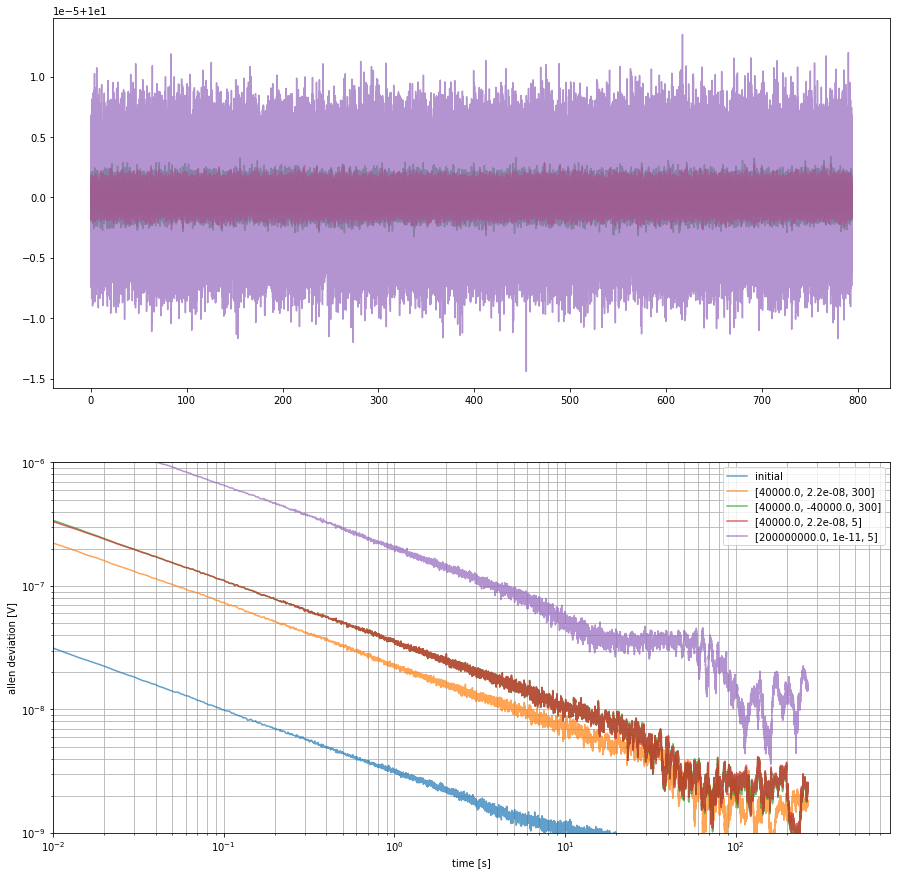

In [10]:
time_step = 0.002 # s
rate = 1/time_step
measurements = int(40e4)
time = np.arange(0, measurements*time_step, time_step)
#amplitudes = [5e-6, 4e-6, 2e-6, 1e-6, 5e-7]
amp = 1e-7 # 100nV # SOURCE NOISE (Vpp on Osci, given same sampling rate...)
brownamp = amp/10
pinkamp = amp/5
offset = 10
skip_data = 3000

filters = [
    [40e3, 22e-9, 300], # R, C, T
    [40e3, -40e3, 300], # voltage divider
    [40e3, 22e-9, 5], # exchange filter
    #[100e6, 110e-12, 5], # full w/o resonator / split w/o resonator electrode A
    #[2*100e6, 1110e-12, 5], # PTB guys mentioned R doubles for thick film resistors at 4K
    [2*100e6, 10e-12, 5], # imaginary super bad low capacity filter
    #[100e6, 110e-12, 5], # split w/o resonator electrode B
]

print("Settings:")
print("total time", int(time.max()), "s")
print("sampling rate", int(rate), "1/s")
print("number of samples", len(time), "#")
print("Source noise Vpp (@sampling rate)", amp*1e6, "uV")
print("source output", offset, "V")


def butter_lowpass(cutoff, fs, order=1):
    #print(fs, cutoff)
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

spectral_density = amp/np.sqrt(rate)
signal = at.noise.white(measurements, spectral_density**2, rate) + offset
#signal += at.noise.pink(measurement, depth=80)
#signal += at.noise.brown(measurements, b_minus2=time_step, fs=rate)*brownamp

fig, axs = plt.subplots(2, figsize=(15,15))
axs[0].plot(time[:-skip_data], signal[skip_data:], label='initial', alpha=0.7)
(t2, ad, ade, adn) = at.adev(signal[skip_data:], rate=rate, data_type="freq", taus=time[:-1000]) 
axs[1].loglog(t2, ad, label='initial', alpha=0.7)

print("filters: index, R (Ohm), C (F), T (K), f_cutoff (Hz), filter white noise rms (uV), spectral desity (uV/sqrt(Hz))")

#for amp in amplitudes:
for i, filt in enumerate(filters):
    
    if filt[1] < 0:
        spectral_density = np.sqrt(4*sc.constants.k*filt[2]*(filt[0]-filt[1]))
        filter_noise = at.noise.white(measurements, spectral_density**2, rate)
    else:

        cutoff = 1/(2*np.pi*filt[0]*filt[1])
        ktc_noise_rms = np.sqrt(sc.constants.k * filt[2] / filt[1])
        ktc_spectral_density = ktc_noise_rms / np.sqrt(cutoff)
        print(i, filt, int(cutoff), round(ktc_noise_rms*1e6, 3), ktc_spectral_density*1e6)
        # given explaination before, the noise for 
        # ktc filter noise, apply filter to it before adding it
        #filter_noise = at.noise.white(measurements)
        filter_noise = at.noise.white(measurements, ktc_spectral_density**2, rate)
        if cutoff < rate:
            filter_noise = butter_lowpass_filter(filter_noise, cutoff, fs=rate, order=1)
            signal = butter_lowpass_filter(signal, cutoff, fs=rate, order=1)
        else:
            print("filter freq to low")
    
    #signal += filter_noise*ktc_noise_rms*np.sqrt(2)*2 # V rms to V pp conversion
    signal += filter_noise

    axs[0].plot(time[:-skip_data], signal[skip_data:], label=str(filt), alpha=0.7)
    (t2, ad, ade, adn) = at.adev(signal[skip_data:], rate=rate, data_type="freq", taus=time[:-skip_data]) 
    axs[1].loglog(t2, ad, label=str(filt), alpha=0.7)
        
plt.grid(which='both')
plt.xlim([1e-2, time.max()])
plt.ylim([1e-9, 1e-6])
plt.ylabel("allen deviation [V]")
plt.xlabel("time [s]")
plt.legend()
plt.show()


### cross-check with different noise creation function

Settings:
total time 799 s
sampling rate 500 1/s
number of samples 400000 #
Source noise Vpp (@sampling rate) 0.09999999999999999 uV
source output 10 V
test 1e-07 1e-07 1e-07
signal 9.999999999999997e-08
filters: index, R (Ohm), C (F), T (K), f_cutoff (Hz), filter white noise rms (uV)
0 [40000.0, 2.2e-08, 300] 180 0.434 0.4339012769995246


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


1 [40000.0, -40000.0, 300] 0 nan nan


IndexError: index 397000 is out of bounds for axis 0 with size 397000

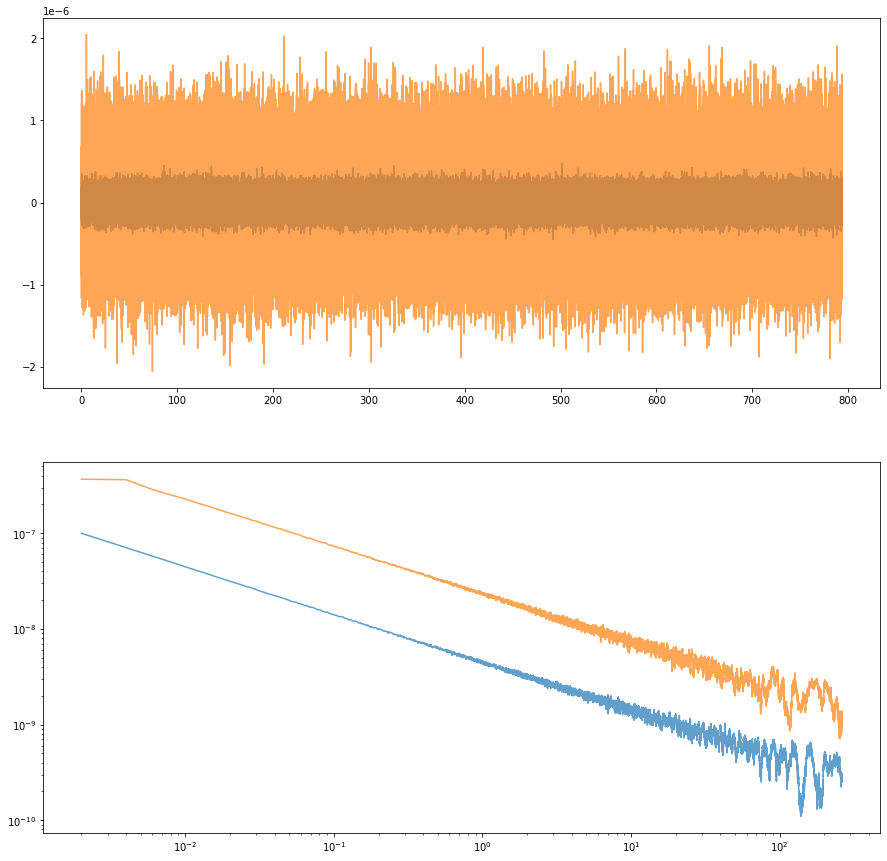

In [11]:
print("Settings:")
print("total time", int(time.max()), "s")
print("sampling rate", int(rate), "1/s")
print("number of samples", len(time), "#")
print("Source noise Vpp (@sampling rate)", amp*1e6, "uV")
print("source output", offset, "V")

def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1 #spectral_noise_density*1e3/np.pi*2 # WHY!?
    return fftnoise(f)

test = band_limited_noise(1e-3, 1e6, measurements, rate)
this_rms = np.sqrt(np.mean(np.square(test)))
test *= amp/this_rms
print("test", amp, np.std(test), np.sqrt(np.mean(np.square(test))) )

signal = band_limited_noise(1e-3, 1e6, measurements, rate)
this_rms = np.sqrt(np.mean(np.square(signal)))
signal *= amp/this_rms
print("signal", np.std(signal))
#signal += offset

fig, axs = plt.subplots(2, figsize=(15,15))
axs[0].plot(time[:-skip_data], signal[skip_data:], label='initial', alpha=0.7)
(t2, ad, ade, adn) = at.adev(signal[skip_data:], rate=rate, data_type="freq", taus=time[:-1000]) 
axs[1].loglog(t2, ad, label='initial', alpha=0.7)

print("filters: index, R (Ohm), C (F), T (K), f_cutoff (Hz), filter white noise rms (uV)")


#for amp in amplitudes:
for i, filt in enumerate(filters):
    cutoff = 1/(2*np.pi*filt[0]*filt[1])
    ktc_noise_rms = np.sqrt(sc.constants.k * filt[2] / filt[1])
    #ktc_spectral_density = ktc_noise_rms / np.sqrt(cutoff)
    filter_noise = band_limited_noise(min_freq=1e-3, max_freq=cutoff, samples=measurements, samplerate=rate)
    this_rms = np.sqrt(np.mean(np.square(filter_noise)))
    filter_noise *= ktc_noise_rms/this_rms
    print(i, filt, int(cutoff), round(ktc_noise_rms*1e6, 3), np.std(filter_noise)*1e6)

    signal += filter_noise

    axs[0].plot(time[:-skip_data], signal[skip_data:], label=str(filt), alpha=0.7)
    (t2, ad, ade, adn) = at.adev(signal[skip_data:], rate=rate, data_type="freq", taus=time[:-skip_data]) 
    axs[1].loglog(t2, ad, label=str(filt), alpha=0.7)
        
plt.grid(which='both')
plt.xlim([1e-1, time.max()])
plt.ylim([1e-10, 1e-6])
plt.ylabel("allen deviation [V]")
plt.xlabel("time [s]")
plt.legend()
plt.show()


In [ ]:
# nochmal nach luis rechnung

In [ ]:
# 3He filters
filters = [
    [820e3, 100e-9, 300], # R, C, T
    [820e3, 22e-9, 70],
    [2*820e3, 22e-9, 5]
]


print("Settings:")
print("total time", int(time.max()), "s")
print("sampling rate", int(rate), "1/s")
print("number of samples", len(time), "#")
print("Source noise Vpp (@sampling rate)", amp*1e6, "uV")
print("source output", offset, "V")

def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1 #spectral_noise_density*1e3/np.pi*2 # WHY!?
    return fftnoise(f)

test = band_limited_noise(1e-3, 1e6, measurements, rate)
this_rms = np.sqrt(np.mean(np.square(test)))
test *= amp/this_rms
print("test", amp, np.std(test), np.sqrt(np.mean(np.square(test))) )

signal = band_limited_noise(1e-3, 1e6, measurements, rate)
this_rms = np.sqrt(np.mean(np.square(signal)))
signal *= amp/this_rms
print("signal", np.std(signal))
#signal += offset

fig, axs = plt.subplots(2, figsize=(15,15))
axs[0].plot(time[:-skip_data], signal[skip_data:], label='initial', alpha=0.7)
(t2, ad, ade, adn) = at.adev(signal[skip_data:], rate=rate, data_type="freq", taus=time[:-1000]) 
axs[1].loglog(t2, ad, label='initial', alpha=0.7)

print("filters: index, R (Ohm), C (F), T (K), f_cutoff (Hz), filter white noise rms (uV)")


#for amp in amplitudes:
for i, filt in enumerate(filters):
    cutoff = 1/(2*np.pi*filt[0]*filt[1])
    ktc_noise_rms = np.sqrt(sc.constants.k * filt[2] / filt[1])
    #ktc_spectral_density = ktc_noise_rms / np.sqrt(cutoff)
    filter_noise = band_limited_noise(min_freq=1e-3, max_freq=cutoff, samples=measurements, samplerate=rate)
    this_rms = np.sqrt(np.mean(np.square(filter_noise)))
    filter_noise *= ktc_noise_rms/this_rms
    print(i, filt, int(cutoff), round(ktc_noise_rms*1e6, 3), np.std(filter_noise)*1e6)

    signal += filter_noise

    axs[0].plot(time[:-skip_data], signal[skip_data:], label=str(filt), alpha=0.7)
    (t2, ad, ade, adn) = at.adev(signal[skip_data:], rate=rate, data_type="freq", taus=time[:-skip_data]) 
    axs[1].loglog(t2, ad, label=str(filt), alpha=0.7)
        
plt.grid(which='both')
plt.xlim([1e-1, time.max()])
plt.ylim([1e-10, 1e-6])
plt.ylabel("allen deviation [V]")
plt.xlabel("time [s]")
plt.legend()
plt.show()


#### RESULTS:

mostly filters do what they supposed to do, if the KTC filter noise is a real thing, than this would eventually limit the minimum white noise contribution, so improving the source would not help.

# BACKUP

no need, but keep

## Low pass filter

In [ ]:
time_step = 0.001 # s
rate = 1/time_step
measurements = 1000000
time = np.arange(0, measurements*time_step, time_step)
amplitudes = [5e-6]#, 4e-6, 2e-6, 1e-6, 5e-7]

drift = +1e-10 # per second
drift = 0 # per second

cutoff = 130 # one RC filter, 40k, 22n
cutoff = 65 # two RC filter, each 40k, 22n
cutoff = 12 # three RC filter, two 40k, 22n + 100Meg, 110p

def butter_lowpass(cutoff, fs, order=6):
    #print(fs, cutoff)
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

for amp in amplitudes:
    brownamp = amp/3
    signal = at.noise.white(measurements)*amp + offset
    signal += at.noise.pink(measurements, depth=80)/5*amp
    signal += at.noise.brown(measurements, b_minus2=time_step, fs=rate)*brownamp
    signal2 = butter_lowpass_filter(signal, cutoff, fs=rate, order=6)

    plt.plot(time[1000:], signal[1000:], label=amp)
    plt.plot(time[1000:], signal2[1000:], label='filtered')
plt.legend()
plt.show()


## Pink noise of different amplitude:

In [ ]:
for amp in amplitudes:
    signal = at.noise.pink(measurements, depth=100)*amp + offset
    signal /= offset
    plt.plot(time, signal, label=amp)
plt.legend()
plt.show()

In [ ]:
for amp in amplitudes:
    signal = at.noise.pink(measurements)*amp + offset
    signal /= offset

    # Compute the overlapping ADEV
    (t2, ad, ade, adn) = at.oadev(signal, rate=rate, data_type="freq", taus=time) 
    plt.loglog(t2, ad, label=amp)
    
plt.legend()
plt.show()
